In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats, integrate
import seaborn as sns

# policy gradient linear function

In [95]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=500, n_features=1, n_informative=1, bias=10, noise=50, tail_strength=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

# scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(np.hstack([X_train, y_train.reshape(-1,1)]))
Xy = ss.transform(np.hstack([X_train, y_train.reshape(-1,1)]))
X_train_sc, y_train_sc = Xy[:, [0]], Xy[:, -1]

In [97]:
def rbf(x, c, h):
    return np.exp(-0.5*(x-c)**2/h**2)

def make_rbfs(x, centers, h):
    X = np.zeros((x.shape[0], len(centers)))
    for i, c in enumerate(centers):
        X[:, [i]] = rbf(x, c=c, h=h)
    return X

def make_polynomial(x, powers):
    X = np.zeros((x.shape[0], len(powers)))
    for i, p in enumerate(powers):
        X[:, [i]] = x**p
    return X

Phi = make_rbfs(X_train_sc, centers=np.arange(-1, 1, 0.1), h=1)
Phi = np.hstack([np.ones((X_train_sc.shape[0], 1)), Phi])

# Phi = make_polynomial(X_train_sc, powers=np.arange(-5, 5, 1))

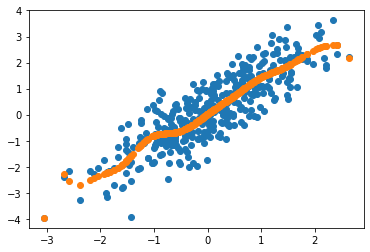

In [98]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor

mod = LinearRegression(fit_intercept=False)
mod.fit(Phi, y_train_sc)
preds = mod.predict(Phi)

plt.scatter(X_train_sc, y_train_sc)
plt.scatter(X_train_sc, preds)

# Discrete auction

## bidder with budget

In [109]:
from utils import ContinuousDistribution, DiscreteDistribution
from MDP.mdp_solver import ValueIteration, PolicyIteration

n_bidders = 5
# dst = stats.lognorm(s=0.5, loc=0, scale=np.exp(0.5))
# dst = stats.uniform(0,10)
# dist = ContinuousDistribution(dst)

dst = stats.geom(p=0.5)
dist = DiscreteDistribution(dst)
print(dist.exp_fos(n_bidders))

budget_init = 6
valuation = 6
states = np.arange(budget_init+1)
actions = np.arange(budget_init+1)

P = np.zeros((states.size, actions.size, states.size))
R = np.zeros((states.size, actions.size, states.size))

for s in range(states.size):
    for a in range(actions.size):
        if s >= a:
            P[s, a, s-a] = dist.fos_cdf(a, n_bidders)
            P[s, a, s] = 1-dist.fos_cdf(a, n_bidders)
        else:
            P[s, a, s] = 1

        if s >= a:
            R[s, a, s-a] = valuation-a
            R[s, 0, s] = 0

4.753341308774637


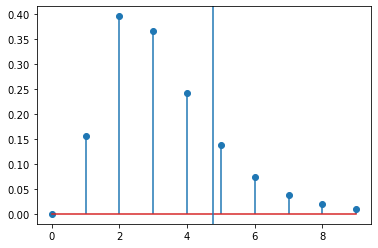

In [110]:
supp = np.arange(10)
# plt.stem(supp, dist.pmf(supp))
plt.stem(supp, dist.fos_pmf(supp, n_bidders))
# plt.stem(supp, dist.sos_pmf(supp, n_bidders))
plt.axvline(dist.exp_fos(n_bidders))

In [119]:
vi = ValueIteration(P, R, gamma=0.99)
policy, V = vi.solve()
V.round(2)

array([ 0.  ,  3.82,  6.7 ,  8.88, 10.53, 12.39, 13.97])

In [120]:
policy

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

In [121]:
s = 6
P[s].round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.97],
       [0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 0.76],
       [0.  , 0.  , 0.  , 0.51, 0.  , 0.  , 0.49],
       [0.  , 0.  , 0.72, 0.  , 0.  , 0.  , 0.28],
       [0.  , 0.85, 0.  , 0.  , 0.  , 0.  , 0.15],
       [0.92, 0.  , 0.  , 0.  , 0.  , 0.  , 0.08]])

In [122]:
R[s]

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 0.],
       [0., 0., 0., 0., 4., 0., 0.],
       [0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [123]:
np.round(P[s]*R[s], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.95, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.54, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.45, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.85, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

## bidder with valuation

In [6]:
n_bidders = 3
dst = stats.lognorm(s=0.5, loc=0, scale=np.exp(1))
dst = stats.uniform(0,5)
dist = Distribution(dst, n_bidders)
print(dist.exp_fos())

budget_init = 10
states = np.arange(budget_init+1)
actions = np.arange(budget_init+1)
valuation = 6

P = np.zeros((states.size, actions.size, states.size))
R = np.zeros((states.size, actions.size, states.size))

for s in range(states.size):
    for a in range(actions.size):
        for sn in range(states.size):
            if s >= a:
                P[s, a, s-a] = dist.fos_cdf(a)
                P[s, a, s] = 1-dist.fos_cdf(a)
            else:
                P[s, a, s] = 1
            
            if s > sn and a <= s:
                R[s, a, sn] = valuation-a
            elif a > s:
                R[s, a, sn] = -10

3.7499999999998734


In [7]:
P[10].round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.99],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.94],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.  , 0.78],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.51, 0.  , 0.  , 0.  , 0.49],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [8]:
R[10]

array([[ 6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  0.],
       [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  0.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  0.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  0.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,  0.],
       [-3., -3., -3., -3., -3., -3., -3., -3., -3., -3.,  0.],
       [-4., -4., -4., -4., -4., -4., -4., -4., -4., -4.,  0.]])

In [9]:
V = np.zeros(states.size)
gamma = 0.995
theta = 1e-10

while True:
    diff = 0
    v = np.copy(V)
    for s in range(states.size):
        V[s] = (P[s] * (R[s]+gamma * v )).sum(axis=1).max()
    diff = np.max([diff, np.max(np.abs(V-v))])
    if diff<= theta:
        break

policy = np.zeros((states.size, actions.size))

for s in range(states.size):
    a = (P[s] * (R[s] + gamma * V)).sum(axis=1).argmax()
    policy[s, a] = 1
    
policy

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [10]:
V

array([ 0.        ,  3.08641975,  4.98209114,  6.58915565,  8.34681951,
        9.83688747, 11.46659095, 12.84817988, 14.35923866, 15.64024599,
       17.04129758])

## bidder with limitless budget

In [11]:
n_bidders = 2
dst = stats.lognorm(s=0.5, loc=0, scale=np.exp(1))
dst = stats.uniform(0,10)
dist = Distribution(dst, n_bidders)
print(dist.exp_fos())

state_names = ['win', 'lose']
states = np.arange(2)
actions = np.arange(11)
valuation = 6

P = np.zeros((states.size, actions.size, states.size))
R = np.zeros((states.size, actions.size, states.size))

for s in range(states.size):
    for a in range(actions.size):
        for sn in range(states.size):
            if s == 0 and sn == 0:
                P[s, a, s] = dist.fos_cdf(a)
                R[s, a, sn] = valuation-a
            elif s == 0 and sn == 1:
                P[s, a, sn] = 1-dist.fos_cdf(a)
            elif s == 1 and sn == 0:
                P[s, a, sn] = dist.fos_cdf(a)
                R[s, a, sn] = valuation-a
            elif s == 1 and sn == 1:
                P[s, a, sn] = 1-dist.fos_cdf(a)

6.666666666557474


In [12]:
V = np.zeros(states.size)
gamma = 0.99
theta = 1e-5

while True:
    diff = 0
    v = np.copy(V)
    for s in range(states.size):
        V[s] = (P[s] * (R[s]+gamma * v )).sum(axis=1).max()
    diff = np.max([diff, np.max(np.abs(V-v))])
    if diff<= theta:
        break

policy = np.zeros((states.size, actions.size))

for s in range(states.size):
    a = (P[s] * (R[s] + gamma * V)).sum(axis=1).argmax()
    policy[s, a] = 1
    
policy

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

## testing

In [13]:
states = np.array([0,1])
actions = np.array([0,1,2])

P = np.array([[[1, 0], [1, 0], [0.8, 0.2]], [[0, 1], [1, 0], [0.6, 0.4]]])
R = np.array([[[2, 0], [0, 0], [5, 5]], [[0, 2], [0, 0], [-3, 5]]])

V = np.zeros(states.size)
gamma = 0.9
theta = 1e-6

while True:
    diff = 0
    v = np.copy(V)
    for s in range(states.size):
        V[s] = (P[s] * (R[s]+gamma * v )).sum(axis=1).max()
    diff = np.max([diff, np.max(np.abs(V-v))])
    if diff<= theta:
        break

policy = np.zeros((states.size, actions.size))

for s in range(states.size):
    a = (P[s] * (R[s] + gamma * V)).sum(axis=1).argmax()
    policy[s, a] = 1
    
print(V)
policy

[42.37287274 38.1355846 ]


array([[0., 0., 1.],
       [0., 1., 0.]])